In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os 
import tensorflow as tf 
from tensorflow.keras.layers import Dense,GlobalAvgPool2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50,VGG16

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6975 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[3 4 1 4 1 1 3 2 1 4 1 1 1 3 2 3 1 1 0 3 3 4 4 4 4 2 3 2 3 0 4 4]


2025-03-14 09:17:05.010163: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-14 09:17:05.830106: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


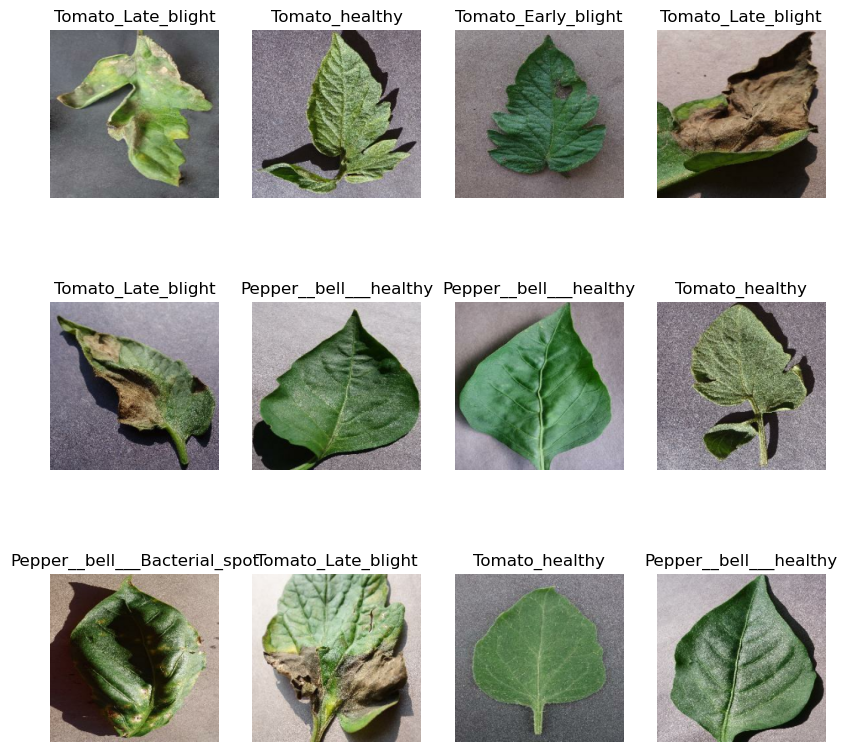

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)


218

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

174

In [11]:
len(val_ds)

21

In [12]:
len(test_ds)

23

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


In [15]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
base_model=VGG16(input_shape=(224, 224, 3),weights='imagenet',include_top=False)

for layer in base_model.layers:
    layer.trainable=False

x=GlobalAveragePooling2D()(base_model.output)
x=Dense(1024,activation='relu')(x)
prediction_layer=Dense(len(class_names),activation='softmax')(x)

model = Model(inputs=base_model.input,outputs=prediction_layer)

model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,245,125 (58.16 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

model.summary()

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1024s 6s/step - accuracy: 0.7505 - loss: 1.2880 - val_accuracy: 0.9271 - val_loss: 0.1973
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 638s 4s/step - accuracy: 0.9172 - loss: 0.2352 - val_accuracy: 0.9226 - val_loss: 0.2412
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 636s 4s/step - accuracy: 0.9376 - loss: 0.1769 - val_accuracy: 0.9554 - val_loss: 0.1325
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 650s 4s/step - accuracy: 0.9466 - loss: 0.1378 - val_accuracy: 0.9271 - val_loss: 0.2271
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 669s 4s/step - accuracy: 0.9522 - loss: 0.1380 - val_accuracy: 0.9628 - val_loss: 0.0935
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 683s 4s/step - accuracy: 0.9502 - loss: 0.1306 - val_accuracy: 0.9390 - val_loss: 0.1441
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 620s 4s/step - accuracy: 0.9585 - loss: 0.1045 - val_accuracy: 0.9583 - val_loss: 0.0961
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 612s 4s/step - accuracy: 0.9623 - loss: 0.1093 - val_acc

In [20]:
scores = model.evaluate(test_ds)

23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9638 - loss: 0.1126


In [33]:
model.save('final_plant_model.h5')

first image to predict
actual label: Pepper__bell___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted label: Pepper__bell___healthy


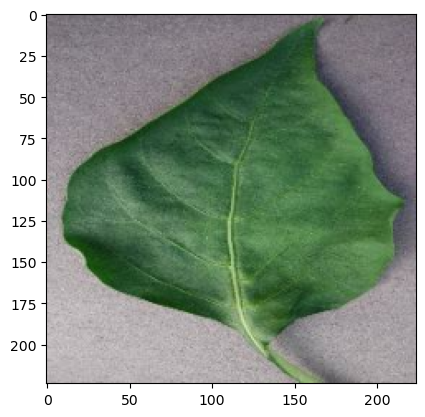

In [29]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
model = tf.keras.models.load_model('plant_disease_model_final.h5')

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


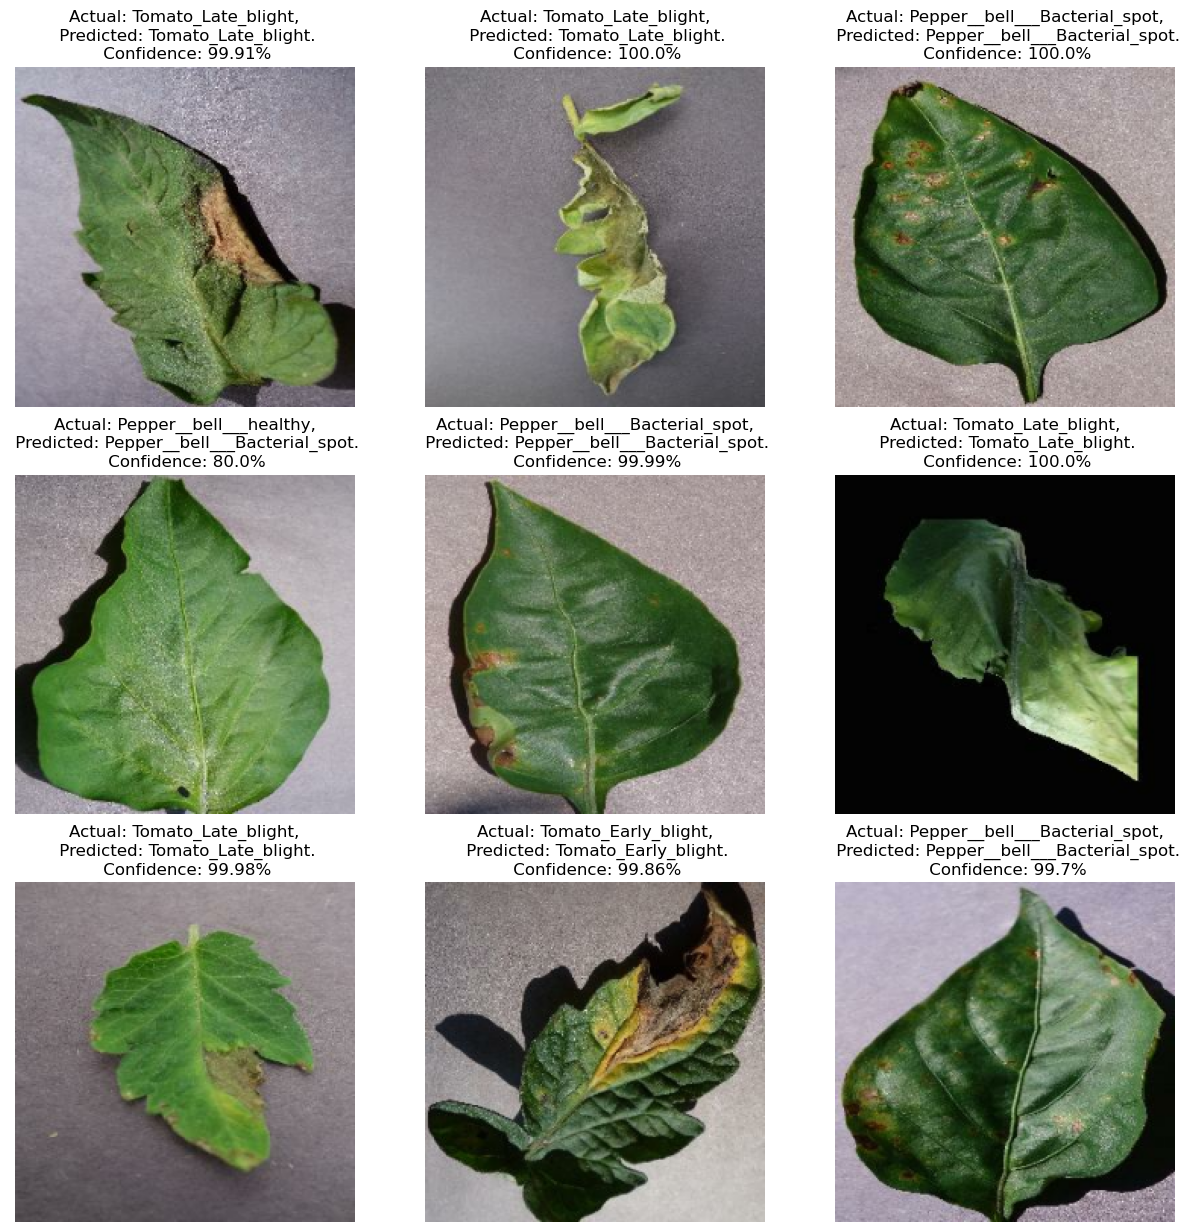

In [42]:
import numpy as np 
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [47]:
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_disease(img_path):
    # Load the image
    img = Image.open(img_path)
    
    # Resize the image
    img = img.resize((224, 224))
    
    # Convert image to array and normalize
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Perform your prediction (assuming you have a model)
    prediction = model.predict(img_array)
    
    return prediction


In [48]:
predict_disease('0a4c007d-41ab-4659-99cb-8a4ae4d07a55___NREC_B.Spot 1954.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


array([[0.09944255, 0.059694  , 0.27530134, 0.4180892 , 0.14747283]],
      dtype=float32)

In [50]:
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

class DiseasePredictor:
    def __init__(self, model_path, class_labels):
        # Load the trained model
        self.model = tf.keras.models.load_model(model_path)
        self.class_labels = class_labels  # List of class names

    def predict_disease(self, img_path):
        # Load and preprocess the image
        img = Image.open(img_path)
        img = img.resize((224, 224))
        img_array = image.img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Get predictions
        predictions = self.model.predict(img_array)
        predicted_class = np.argmax(predictions)  # Get the index of max confidence
        class_name = self.class_labels[predicted_class]  # Get the class label
        
        return class_name, predictions[0][predicted_class]  # Return class and confidence score

# Example usage:
model_path = "final_plant_model.h5"
class_labels = class_names  # Update based on your dataset

predictor = DiseasePredictor(model_path, class_labels)
predicted_class, confidence = predictor.predict_disease('0a9cfb27-280e-475a-bbb4-8eeaeff38b8c___NREC_B.Spot 9177.JPG')

print(f"Predicted Disease: {predicted_class} with confidence {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Predicted Disease: Tomato_Late_blight with confidence 0.39
